# AleRCE query of new LRN precursor candidates

### Prerequisites

In [3]:
import pandas as pd
import psycopg2
import requests

In [4]:
from alerce.core import Alerce
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
credentials_file = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(credentials_file).json()["params"]

In [6]:
conn = psycopg2.connect(dbname=params["dbname"], user=params["user"], host=params["host"], password=params["password"])

In [7]:
from astropy.time import Time
nt = Time.now()

In [8]:
client = Alerce()

## Query the "objects" table

Objective 1: Get the list of alerts from last 30 days

Objective 2: Keep only new objects (at least 2 in last 30 days, max 4 since beginning of ZTF)

#### Query objects having a detection in the last 30 days, and first detected in the last 100 days
NB: this is only a subset of "page_size" (10000) objects.
* To run the next steps quickly, decrease "page_size"
* To run on a different subset, change the "page" parameter

True


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF19admrlio,5,1842,58695.247407,60326.566817,True,False,2,NaN,NaN,...,60326.566817,0.002581,280.115256,26.452187,0.067132,0.060104,None,None,None,23.12.25
1,ZTF21abnzrps,4,1755,58575.473553,60326.566817,True,False,2,NaN,NaN,...,60326.566817,0.007755,281.454562,28.688886,0.068515,0.060104,None,None,None,23.12.25
2,ZTF24aaczrji,2,1724,60326.559063,60326.566817,True,False,2,NaN,NaN,...,60326.566817,0.007755,281.182695,23.364279,0.065473,0.060104,None,None,None,23.12.25
3,ZTF24aaczxuo,2,1570,60326.556458,60326.566817,True,False,2,NaN,NaN,...,60326.566817,0.010359,279.995056,24.446161,0.066023,0.060104,None,None,None,23.12.25
4,ZTF24aaczxee,3,1721,58349.270926,60326.566817,True,False,2,NaN,NaN,...,60326.566817,0.007755,278.200918,23.370406,0.065476,0.060104,None,None,None,23.12.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,ZTF23abunpsr,2,859,60293.406412,60326.457106,True,False,2,NaN,NaN,...,60326.457106,33.050695,92.186117,82.927722,0.419369,0.051633,None,None,None,23.12.20
822,ZTF20adhwgww,5,1029,59127.426736,60326.457106,True,False,2,NaN,NaN,...,60326.457106,0.000000,81.924704,81.234668,0.301612,0.045962,None,None,None,23.12.25
823,ZTF24aacykcv,2,3840,60326.452789,60326.454201,False,False,2,NaN,NaN,...,60326.454201,0.001412,132.090214,36.915266,0.057487,0.045962,None,None,None,23.12.25
824,ZTF24aacymov,2,4518,60326.453727,60326.454201,False,False,2,NaN,NaN,...,60326.454201,0.000475,128.002535,39.952739,0.059958,0.045962,None,None,None,23.12.25


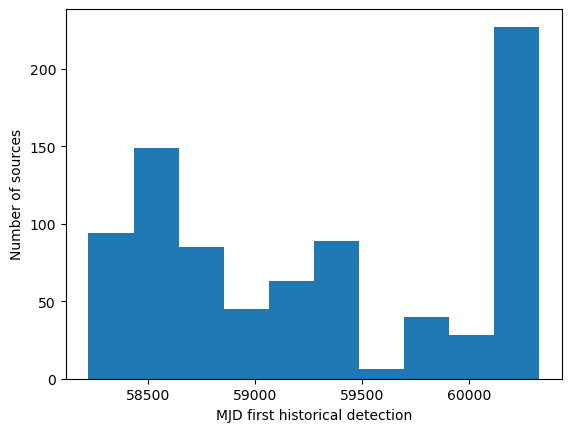

In [301]:
first_mjd_min = nt.mjd-100
last_mjd_min = nt.mjd - 3
mjd_one_month_ago = nt.mjd - 30

query_results = client.query_objects(
        firstmjd = [first_mjd_min, nt.mjd],
        lastmjd = [last_mjd_min, nt.mjd],
        ndet = np.arange(2,5),
        page = 1,
        page_size = 150000,
        order_by = "lastmjd",
        order_mode = "DESC",
        format = 'pandas')

# Remove objects having more than 5 detections in ZTF history
query_results = query_results.loc[np.asarray(query_results['ndethist']).astype(float)<=5]
query_results = query_results.reset_index(drop=True)

# Plot MJD of first detection in ZTF history
plt.hist(query_results['mjdstarthist'])
plt.xlabel("MJD first historical detection")
plt.ylabel("Number of sources")

query_results

In [302]:
# Initialize variables to make new columns later
gooddet = np.zeros(len(query_results))
maxrb = np.zeros(len(query_results))
maxrmag = np.zeros(len(query_results))
minrmag = np.zeros(len(query_results))
maxgmag = np.zeros(len(query_results))
mingmag = np.zeros(len(query_results))

## Query the "detections" table

Objective 3: Keep only objects with a matching star in the reference image

Objective 4: Remove objects with bad RB

In [303]:
for i in tqdm(range(len(query_results))):
    oid = query_results['oid'][i]
    try:
        query_results2 = client.query_detections(oid=oid,format='pandas')
    except:
        print("API error on iteration", i)
        continue
        
    if len(query_results2)==0:
        # object is not detected in current database. Next
        continue
    if query_results2['drb'].max()<0.8:
        # object is likely spurious. Next
        continue
    if np.abs(query_results2['distnr']).max()>1.5:
        # object has no counterpart in the reference image (search radius 1.5 arcsec). Next
        continue
    # Number of positive detections (brighter than reference) in the last 30 days
    gooddet[i] = np.count_nonzero(query_results2['mjd']*query_results2['isdiffpos']>mjd_one_month_ago)
    if gooddet[i]<2:
        # less than 2 positive detections in the last 30 days
        continue
    maxrb[i] = np.max(query_results2['rb'])
    maxrmag[i] = np.max(query_results2.loc[query_results2['fid']==2]['magpsf_corr'])
    minrmag[i] = np.min(query_results2.loc[query_results2['fid']==2]['magpsf_corr'])
    maxgmag[i] = np.max(query_results2.loc[query_results2['fid']==1]['magpsf_corr'])
    mingmag[i] = np.min(query_results2.loc[query_results2['fid']==1]['magpsf_corr'])


100%|████████████████████████████████████████████████████████████████████████████████| 826/826 [01:42<00:00,  8.07it/s]


Text(0, 0.5, 'Number of sources')

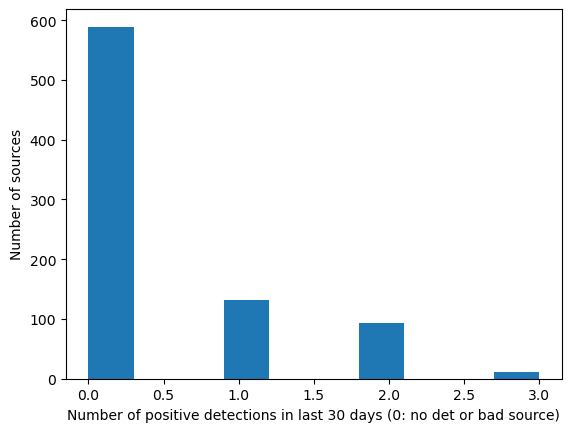

In [304]:
# only objects in current database, non-spurious and with a counterpart in the reference image have a nonzero "gooddet" value
plt.hist(gooddet)
plt.xlabel("Number of positive detections in last 30 days (0: no det or bad source)")
plt.ylabel("Number of sources")

In [305]:
query_results['ngooddet'] = gooddet.astype(int)
query_results['maxrb'] = maxrb
query_results['maxrmag'] = maxrmag
query_results['minrmag'] = minrmag
query_results['maxgmag'] = maxgmag
query_results['mingmag'] = mingmag 

# keep only objects having varied by more than 0.5mag in green or red filter
query_results = query_results.loc[np.logical_or(query_results['maxgmag']-query_results['mingmag']>0.5,
                                                query_results['maxrmag']-query_results['minrmag']>0.5)].reset_index(drop=True)

# keep only objects having at least 2 detections in last 30 days
query_results = query_results.loc[query_results['ngooddet']>1].reset_index(drop=True)
query_results

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,class,classifier,probability,step_id_corr,ngooddet,maxrb,maxrmag,minrmag,maxgmag,mingmag
0,ZTF24aaczprv,2,846,60326.563287,60326.565868,True,False,2,NaN,NaN,...,None,None,None,0.0.0,2,0.928571,18.317270,16.522861,NaN,NaN
1,ZTF24aacztze,3,401,60326.557118,60326.564884,True,False,2,NaN,NaN,...,None,None,None,23.12.25,2,0.614286,15.488975,14.448212,NaN,NaN
2,ZTF24aacytpv,2,1850,60315.547778,60326.493646,True,False,2,NaN,NaN,...,None,None,None,23.12.25,2,0.691429,NaN,NaN,20.31925,19.739244


## SQL queries to get other information

Goal 5: Magnitude increase criterion

In [22]:
query_str = """
SELECT 
     oid, ssdistnr, ssmagnr
FROM ss_ztf p
WHERE
     p.oid IN ('ZTF23abuqecf')
"""
candidates = pd.read_sql(query_str,conn)
print(candidates.shape)
candidates

(0, 3)


C:\Users\hgtra\AppData\Local\Temp\ipykernel_21740\2667860373.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  candidates = pd.read_sql(query_str,conn)


,oid,ssdistnr,ssmagnr


In [307]:
query_results['distnr'] = candidates['distpsnr1']
query_results['gmagref'] = candidates['sgmag1']
query_results['rmagref'] = candidates['srmag1']

# keep only objects having brightened by 3 magnitudes in g or r band
query_results = query_results.loc[np.logical_or(query_results['minrmag']<query_results['rmagref']-3,
                                                query_results['mingmag']<query_results['gmagref']-3)].reset_index(drop=True)
query_results

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,step_id_corr,ngooddet,maxrb,maxrmag,minrmag,maxgmag,mingmag,distnr,gmagref,rmagref
0,ZTF24aaczprv,2,846,60326.563287,60326.565868,True,False,2,NaN,NaN,...,0.0.0,2,0.928571,18.317270,16.522861,NaN,NaN,0.176019,22.1694,22.1959
1,ZTF24aacztze,3,401,60326.557118,60326.564884,True,False,2,NaN,NaN,...,23.12.25,2,0.614286,15.488975,14.448212,NaN,NaN,0.245015,21.6122,20.3649


### Open the resulting objects in the ALeRCE explorer

In [308]:
url = "https://alerce.online/?" + "&".join(["oid=%s" % oid for oid in query_results.oid.values]) + "&count=true&page=1&perPage=1000&sortDesc=false"
print(url)

https://alerce.online/?oid=ZTF24aaczprv&oid=ZTF24aacztze&count=true&page=1&perPage=1000&sortDesc=false


In [ ]:
conn.close()

## Draft zone

In [ ]:
# Random position in Galactic plane
objects_str = "('source_1', 49.0189, 56.3074)"
search_radius = 2 # degrees

In [ ]:
query = """
WITH catalog ( source_id, ra, dec) AS (
    VALUES
        {values}
)
SELECT 
    c.source_id, c.ra, c.dec, o.oid, o.meanra, o.meandec, q3c_dist(c.ra,c.dec,o.meanra,o.meandec), 
    o.ndethist, o.mjdstarthist, o.firstmjd, o.lastmjd

FROM object o, catalog c
    /*
     * It is REALLY important to first use the catalog then the object ra,dec for speed. The radius is in degrees.
     */
WHERE
    q3c_join(c.ra, c.dec,o.meanra, o.meandec, {radius})
    AND o.lastmjd > %s
    AND o.ndethist < 5
    AND o.ndet >= 2
LIMIT 100
""" % (last_mjd_discovery)
query_str = query.format(values = objects_str, radius = search_radius) # radius in degrees

In [ ]:
query = """
SELECT 
    o.oid, o.meanra, o.meandec, 
    o.ndethist, o.mjdstarthist, o.firstmjd, o.lastmjd

FROM object o
    /*
     * It is REALLY important to first use the catalog then the object ra,dec for speed. The radius is in degrees.
     */
WHERE
    o.lastmjd > %s
    AND o.ndethist < 5
    AND o.ndet >= 2
LIMIT 5000
""" % (last_mjd_discovery)
query_str = query.format(values = objects_str, radius = search_radius) # radius in degrees

In [ ]:
query_str = """
SELECT 
    m.oid, m.magfirst, m.maglast, m.ndet, m.magsigma, m.firstmjd, m.lastmjd
FROM magstat m
    /*
     * Query objects having >=2 det and brightened >3 mag between first and last and observed in last 30d
     */
WHERE
    m.lastmjd > %s
    AND m.magfirst-m.maglast > 3
LIMIT 10
""" % (last_mjd_discovery)
# Comment : magsigma is the standard deviation of the time series, NOT the magnitude uncertainty!!

In [ ]:
query_str = """
SELECT 
     d.oid, COUNT(d.mjd) AS ndet, MAX(d.rb) AS rbmax, MIN(d.distnr) AS distref, MIN(d.magpsf) AS magmin, MAX(d.magpsf) AS magmax
FROM detection d
    /*
     * Query objects having >=2 det and brightened >3 mag between first and last and observed in last 30d
     */
WHERE
    d.mjd > %s
    AND d.distnr<1.5
    AND d.rb>0.8
    AND d.drb>0.8
    AND d.sigmapsf<0.1
GROUP BY d.oid
LIMIT 10
""" % (last_mjd_discovery)

In [ ]:
query_str = """
SELECT 
     f.oid, COUNT(f.mjd) AS ndet, MIN(f.distnr) AS distref, MIN(f.magnr) AS magref, MIN(f.mag) AS magmin, MIN(f.e_mag) AS errmin, MAX(f.mag) AS magmax
FROM forced_photometry f
    /*
     * Query objects having >=2 det and brightened >3 mag between first and last and observed in last 30d
     */
WHERE
    f.mjd > %s
    AND f.distnr<1.5
    AND f.e_mag<0.1
GROUP BY f.oid
LIMIT 10
""" % (last_mjd_discovery)

In [ ]:
query='''
SELECT
    oid, COUNT(mjd) AS ndet, MAX(fid) AS fidmax, MIN(fid) AS fidmin, MAX(magpsf) AS magmax, MIN(magpsf) AS magmin, MAX(rb) AS rbmax, MAX(drb) AS drbmax, MIN(distnr) AS distref
FROM
    detection
WHERE
    oid in (%s)
    AND rb > 0.8
    AND drb > 0.8
    AND distnr < 1.5
    AND sigmapsf < 0.1
    AND mjd > %s
    AND isdiffpos = 1
GROUP BY oid
''' % (",".join(["'%s'" % oid for oid in matches['oid']]),
       last_mjd_discovery)


In [ ]:
#oid_gooddet = pd.read_sql_query(query, conn)
#print(oid_gooddet.shape)
#oid_gooddet

#### NB: use other date columns. jdstarhist, jdendhist, jdstartref, jdendref

##### Uncomment next cell to run a query

In [ ]:
#matches = pd.read_sql(query_str,conn)
#print(matches.shape)
#matches

In [309]:
nt.mjd

60328.57839074551